### Model Predictive Controller (MPC) Design



In [370]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import fractional_matrix_power

# The system matrices are given as those of the Kothare's paper (please see the page 11).
A1 = np.matrix([[0.9347, 0.5194],[0.3835, 0.8310]])
A2 = np.matrix([[0.0591, 0.2641],[1.7971, 0.8717]])

B = np.matrix([[-1.4462],[-0.7012]])

# Simulation parmeters
umax = 47.0 # Feasible solution can be obtained upto umax=47.0
n=A1.shape[0]
b=B.shape[1]
x0=np.matrix([[0.1],[-0.1]])
temp_x = np.matrix([[1]])

I = np.identity(n)
Ib = np.identity(b)
Zn = np.zeros((n,n))
Znb = np.zeros((n,b))

Q=I
R=Ib
Qf = fractional_matrix_power(Q, 0.5)
Rf = fractional_matrix_power(R, 0.5)

# Decision variable matrices are defined.
P = cp.Variable((n,n), PSD=True)
Y = cp.Variable((b,n))
gamma = cp.Variable((1,1))

#gamma = float(1)
# LMI conditions
LMI1 = cp.bmat([[P, P*A1.T+Y.T*B.T, P*Qf, Y.T*Rf],
        [(P*A1.T+Y.T*B.T).T, P, Zn, Znb],
        [(P*Qf).T, Zn, gamma*I, Znb],
        [(Y.T*Rf).T, Znb.T, Znb.T, gamma*Ib]])

LMI2 = cp.bmat([[P, P*A2.T+Y.T*B.T, P*Qf, Y.T*Rf],
        [(P*A2.T+Y.T*B.T).T, P, Zn, Znb],
        [(P*Qf).T, Zn, gamma*I, Znb],
        [(Y.T*Rf).T, Znb.T, Znb.T, gamma*Ib]])

LMI3 = cp.bmat([[temp_x, x0.T],[x0, P]])

LMI4 = cp.bmat([[(umax**2)*Ib, Y],[Y.T, P]])

objective = cp.Minimize(gamma)
prob = cp.Problem(objective, [LMI1 >= 0,LMI2 >= 0, LMI3 >= 0, LMI4 >= 0, P - 0.01*I >> 0, gamma - 0.1>> 0])
prob.solve()
print("status:", prob.status)
print("optimal value", prob.value)

Pop = P.value
Yop = Y.value

Pinv = np.linalg.inv(Pop)
K = np.matmul(Yop,Pinv)
print(K)
# K1 = Yop@Pinv, K1 is the same as K

#[sys_stab1,sys_vec1] = np.linalg.eig(A1+B@K)
#[sys_stab2,sys_vec2] = np.linalg.eig(A2+B@K)
#print(sys_stab1)
#print(sys_stab2)


status: optimal
optimal value 0.1000000283458232
[[0.03277576 0.15096502]]


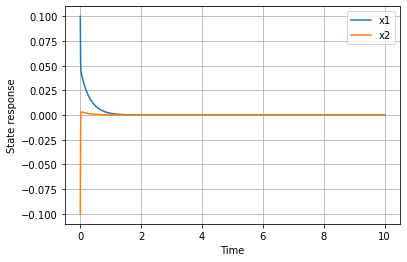

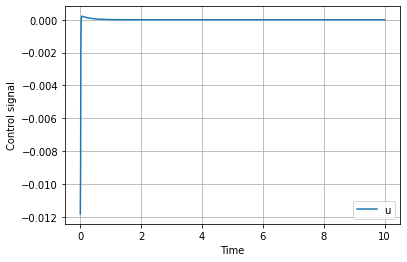

In [371]:
# Simulation
x0 = np.array(x0)
dx = np.zeros([n,b])
temp_p = np.zeros([n,b])

T=0.01
tf=10
sam=int(tf/T)
tspan = np.linspace(0,tf, sam+1)

xs=len(tspan)
x=np.zeros([n,xs])
xhat=np.zeros([n,xs])
u_sig=np.zeros([B.shape[1],xs])
x[0,0]=x0[0]
x[1,0]=x0[1]

# K is obtained by using linear–quadratic regulator 
u_sig[:,0] = np.matmul(K,x[:,0])

for i in range(0,xs-1):
    u = np.matmul(K5,x[:,i])
    #sig = (0.5)*np.sin(i*T)+0.5
    sig = 1
    

    dx1 = sig*(0.9347*x[0,i]+0.5194*x[1,i]) + (1-sig)*(0.3835*x[0,i]+0.8310*x[1,i]) -1.4462*u
    dx2 = sig*(0.0591*x[0,i]+0.2641*x[1,i]) + (1-sig)*(1.7971*x[0,i]+0.8717*x[1,i]) -0.7012*u
    
    x[0,i+1] = dx1
    x[1,i+1] = dx2

    u_sig[:,i+1] = u

plt.figure()
plt.plot(tspan, x[0,:], label = "x1")
plt.plot(tspan, x[1,:], label = "x2")
plt.grid()
plt.xlabel("Time")
plt.ylabel("State response")
plt.legend()
plt.show()

plt.figure()
plt.plot(tspan, u_sig[0,:], label = "u")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Control signal")
plt.legend()
plt.show()

